In [17]:
import importlib
import os
import json
import sys

import numpy as np
import torch
import torchvision

from PIL import Image

from models.gan_visualizer import GANVisualizer
from models.utils.utils import loadmodule, getLastCheckPoint, getVal, \
    getNameAndPackage, parse_state_name

In [6]:
name = "hina"
module = "PGAN"
scale = None
iter = None
dir = "output_networks"
visualisation = importlib.import_module("visualization.np_visualizer")

In [7]:
checkPointDir = os.path.join(dir, name)
checkpointData = getLastCheckPoint(checkPointDir,
                                    name,
                                    scale=scale,
                                    iter=iter)
if checkpointData is None:
    raise FileNotFoundError(
        "Not checkpoint found for model " + name + " at directory " + dir)

modelConfig, pathModel, _ = checkpointData
if scale is None:
    _, scale, _ = parse_state_name(pathModel)

In [8]:
pathLoss = os.path.join(checkPointDir, name + "_losses.pkl")
pathOut = os.path.splitext(pathModel)[0] + "_fullavg.jpg"

packageStr, modelTypeStr = getNameAndPackage(module)
modelType = loadmodule(packageStr, modelTypeStr)
exportMask = module in ["PPGAN"]

visualizer = GANVisualizer(
    pathModel, modelConfig, modelType, visualisation)

Average network found !


## Generate

In [19]:
batch_size = 49
z, _ = visualizer.model.buildNoiseData(batch_size)
z.shape

torch.Size([49, 512])

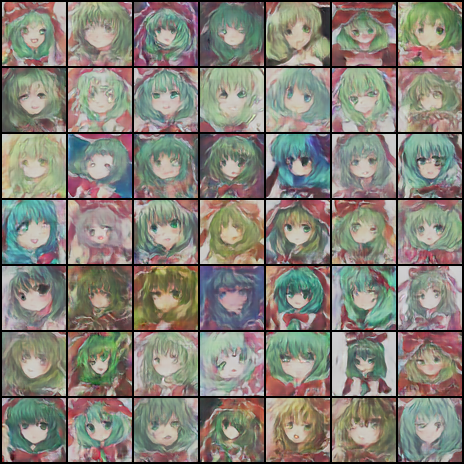

In [228]:
from copy import deepcopy

t = 0.3
fz = deepcopy(z[25].unsqueeze(0))*t + z[2].unsqueeze(0)*(1-t)
# fz[0,290] = 2.7
img = visualizer.model.test(z, getAvG=True)
fav = visualizer.model.test(fz, getAvG=True)
grid = torchvision.utils.make_grid(img, nrow=7, normalize=True).numpy().transpose(1,2,0)
fav = torchvision.utils.make_grid(fav, nrow=1, normalize=True).numpy().transpose(1,2,0)

Image.fromarray((grid*255).astype(np.uint8))


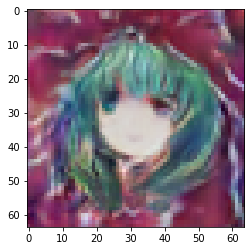

In [229]:
import matplotlib.pyplot as plt
# Image.fromarray((fav*255).astype(np.uint8)).save("fav6.jpg")
plt.imshow(fav)

tensor(340, device='cuda:0')

In [171]:
np.save("fav6.npy", fz.cpu().numpy())

## Interpolate

In [172]:
fz1 = torch.tensor(np.load("fav1.npy")).cuda()
fz2 = torch.tensor(np.load("fav6.npy")).cuda()

In [173]:
pathOut = os.path.splitext(pathModel)[0] + "_interpolations"
os.makedirs(pathOut, exist_ok=True)
interpolationVectors = torch.cat([fz1, fz2])

In [174]:
nImgs = interpolationVectors.size(0)
for img in range(nImgs):

    indexNext = (img + 1) % nImgs
    path = os.path.join(pathOut, str(img) + "_" + str(indexNext))

    if not os.path.isdir(path):
        os.mkdir(path)

    path = os.path.join(path, "")

    visualizer.saveInterpolation(
        100, interpolationVectors[img],
        interpolationVectors[indexNext], path)

## Mofing Video

In [11]:
import cv2

img_dir = "./output_networks/hina/hina_s4_i96000_interpolations/0_1/"
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('mofing.avi', fourcc, 15.0, (64,64))

for fname in sorted(os.listdir(img_dir)):
    fpath = os.path.join(img_dir, fname)
    frame = cv2.imread(fpath)

    # write the flipped frame
    out.write(frame)
# Release everything if job is finished
out.release()

In [1]:
print(1)

1
